In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord

from simladb import query, simladb, simladbX, DB_bcd, DB_shardpos, \
                    DB_judge1, DB_judge2, DB_bcdwise, scorners
from simla_variables import SimlaVar
from simla_utils import fmt_scorners, zoom_image

import validation_funcs

/Users/grant/anaconda3/envs/simlaenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sl_n_shards = SimlaVar().sl_n_shards
ll_n_shards = SimlaVar().ll_n_shards
simlapath = SimlaVar().simlapath
irspath = SimlaVar().irspath
wisepath = SimlaVar().wisepath
plotpath = simlapath+'validations/plots/'

# Table Entry Number Validation

In [3]:
# The best way to compare is to count the actual number of BCDs in the data directory
true_n_sl_bcds = len(glob.glob(irspath+'**/**/ch0/**/*bcd.fits'))
true_n_ll_bcds = len(glob.glob(irspath+'**/**/ch2/**/*bcd.fits'))
true_sl_shards, true_ll_shards = \
    true_n_sl_bcds*(sl_n_shards*2), true_n_ll_bcds*(ll_n_shards*2)
true_total_shards = true_sl_shards + true_ll_shards
print('True number of SL shards: '+str(true_sl_shards))
print('True number of LL shards: '+str(true_ll_shards))
print('True number of all shards: '+str(true_total_shards))

True number of SL shards: 3469710
True number of LL shards: 2743860
True number of all shards: 6213570


In [4]:
# Compare with what the joined table says
qshardnum_sl = len(query(simladb.select(DB_bcd.DCEID).where(DB_bcd.CHNLNUM==0))['DCEID'])
qshardnum_ll = len(query(simladb.select(DB_bcd.DCEID).where(DB_bcd.CHNLNUM==2))['DCEID'])
print('Database number of SL shards: '+str(qshardnum_sl))
print('Database number of LL shards: '+str(qshardnum_ll))
print('Database number of all shards: '+str(qshardnum_sl+qshardnum_ll))

Database number of SL shards: 3469710
Database number of LL shards: 2743860
Database number of all shards: 6213570


# Judge Photometry Comparisons

In [5]:
q_shardphot = query(simladbX.select(DB_judge1.BACKSUB_PHOT, DB_judge2.F_MEDIAN, \
                                   DB_shardpos.CHNLNUM, DB_shardpos.SUBORDER, DB_shardpos.SHARD)\
                            .where((DB_judge1.BACKSUB_PHOT!=0.0)))
j1s, j2s, chnls, subs, shards, = \
    q_shardphot['BACKSUB_PHOT'].to_numpy(), q_shardphot['F_MEDIAN'].to_numpy(), \
    q_shardphot['CHNLNUM'].to_numpy(), q_shardphot['SUBORDER'].to_numpy(), q_shardphot['SHARD'].to_numpy()

/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/4272311154.py:9: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/4272311154.py:10: RuntimeWarning: divide by zero encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/4272311154.py:10: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))


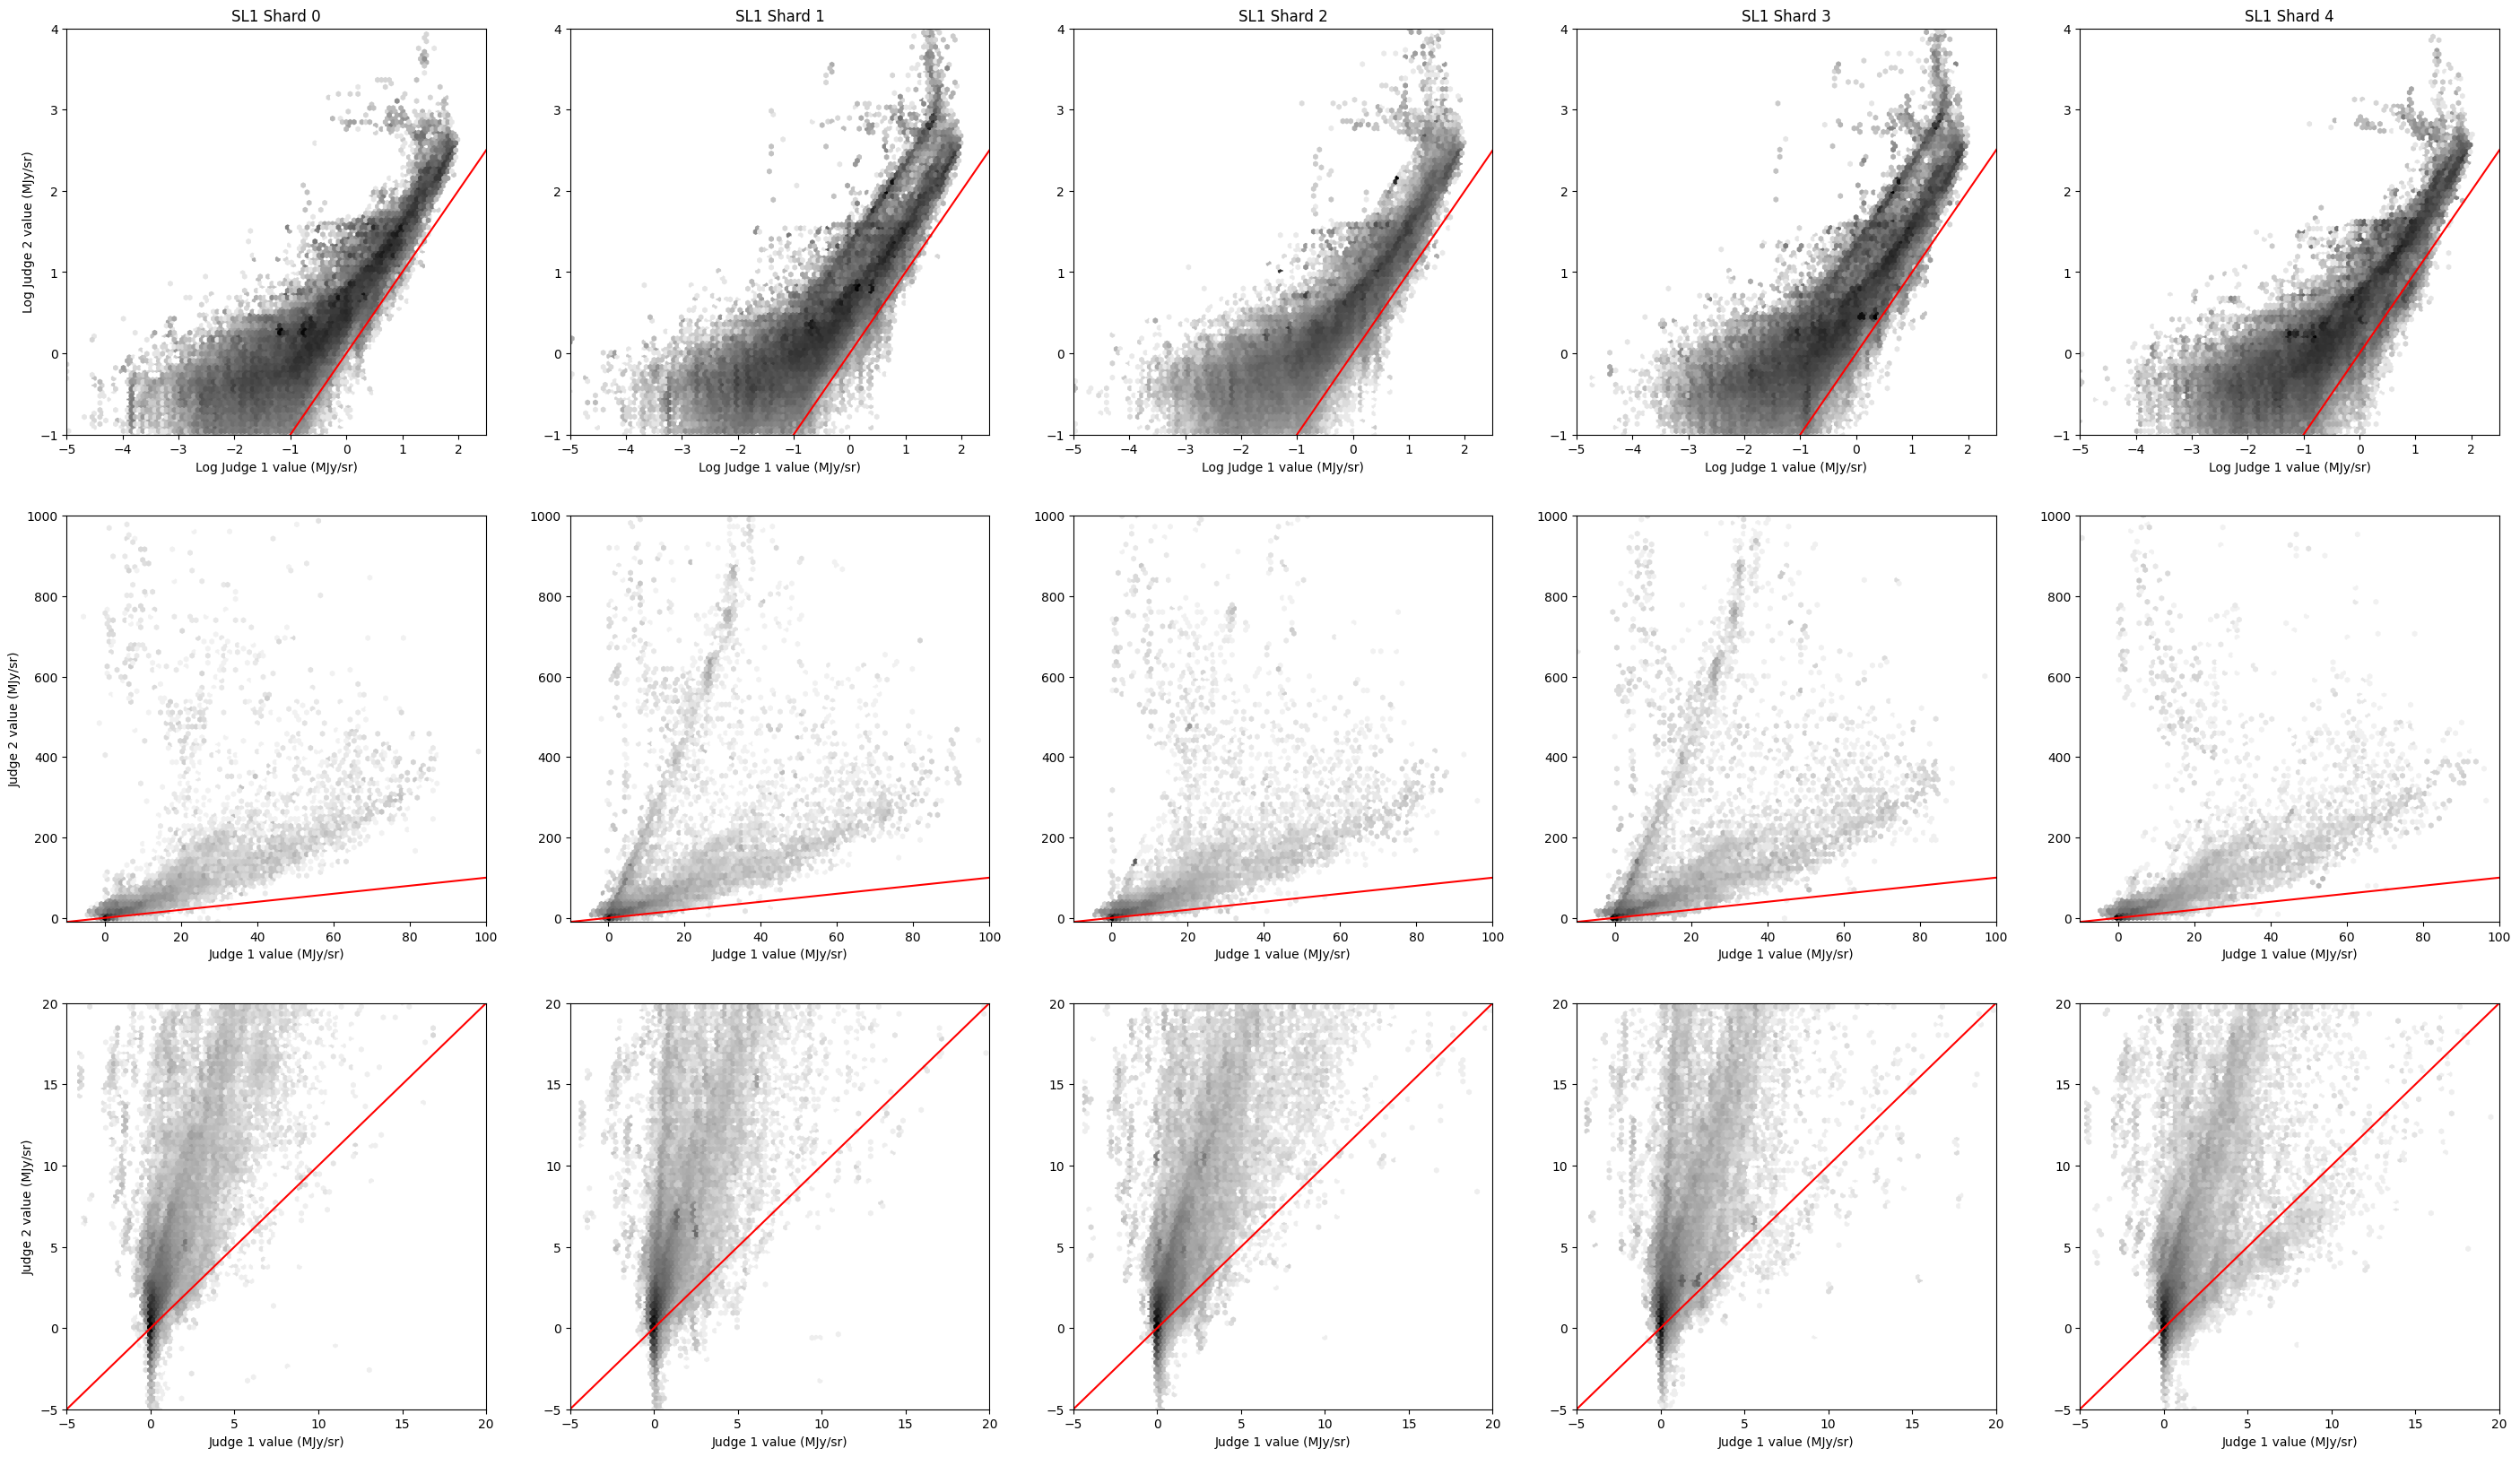

In [6]:
# SL1
fig, axs = plt.subplots(3, sl_n_shards, figsize=(35, 20))
xy = np.linspace(-10**10, 10**10)
xlim = (-5, 2.5)
ylim = (-1, 4)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, i+1)
    mask = np.where((chnls==0)&(subs==1)&(shards==i)&\
                   ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
                   ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
    j1, j2 = np.log10(j1s[mask]), np.log10(j2s[mask])
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.title('SL1 Shard '+str(i))
    plt.xlabel('Log Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Log Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-10, 100)
ylim = (-10, 10**3)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, (i+1)+sl_n_shards)
    mask = np.where((chnls==0)&(subs==1)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-5, 20)
ylim = (-5, 20)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, (i+1)+(sl_n_shards*2))
    mask = np.where((chnls==0)&(subs==1)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
plt.savefig(plotpath+'/judge_comparisons/SL1_judge_comparisons.pdf', format='pdf')
plt.show()

/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3660964233.py:9: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3660964233.py:10: RuntimeWarning: divide by zero encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3660964233.py:10: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))


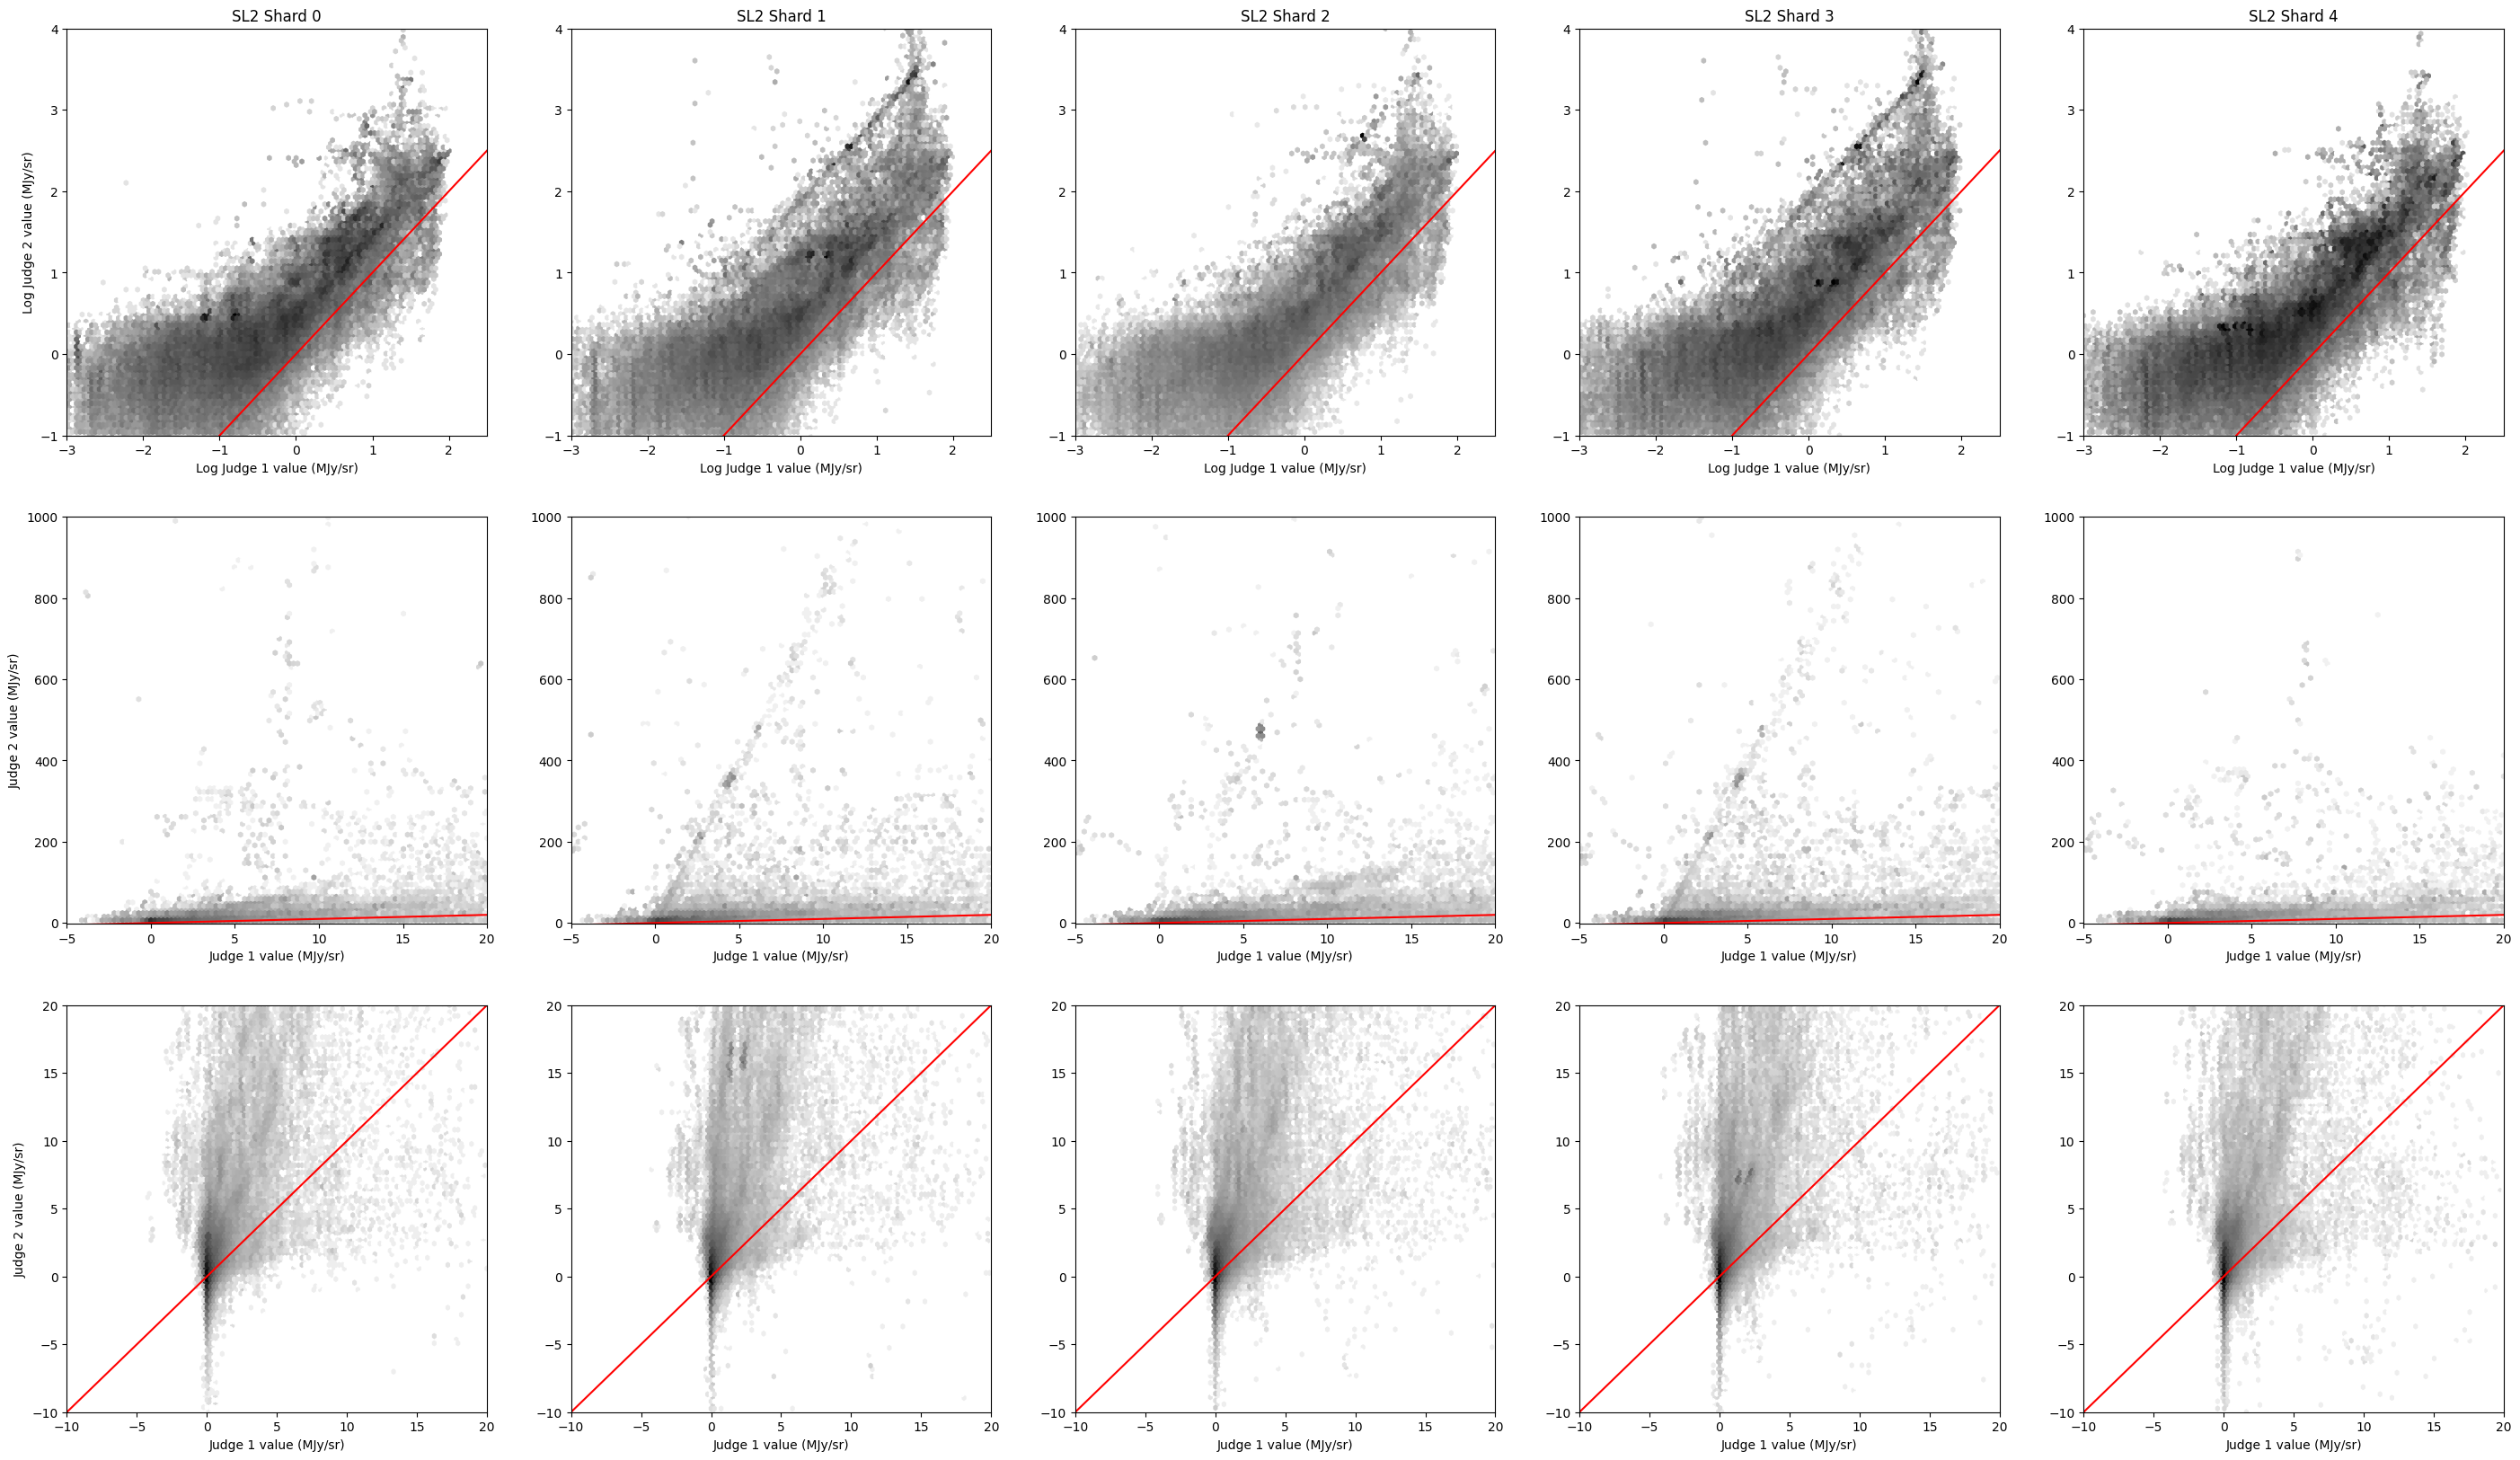

In [7]:
# SL2
fig, axs = plt.subplots(3, sl_n_shards, figsize=(35, 20))
xy = np.linspace(-10**10, 10**10)
xlim = (-3, 2.5)
ylim = (-1, 4)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, i+1)
    mask = np.where((chnls==0)&(subs==2)&(shards==i)&\
                   ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
                   ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
    j1, j2 = np.log10(j1s[mask]), np.log10(j2s[mask])
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.title('SL2 Shard '+str(i))
    plt.xlabel('Log Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Log Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-5, 20)
ylim = (-2, 1000)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, (i+1)+sl_n_shards)
    mask = np.where((chnls==0)&(subs==2)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-10, 20)
ylim = (-10, 20)
for i in range(sl_n_shards):
    plt.subplot(3, sl_n_shards, (i+1)+(sl_n_shards*2))
    mask = np.where((chnls==0)&(subs==2)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
plt.savefig(plotpath+'/judge_comparisons/SL2_judge_comparisons.pdf', format='pdf')
plt.show()

/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/2218953234.py:9: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/2218953234.py:10: RuntimeWarning: divide by zero encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/2218953234.py:10: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))


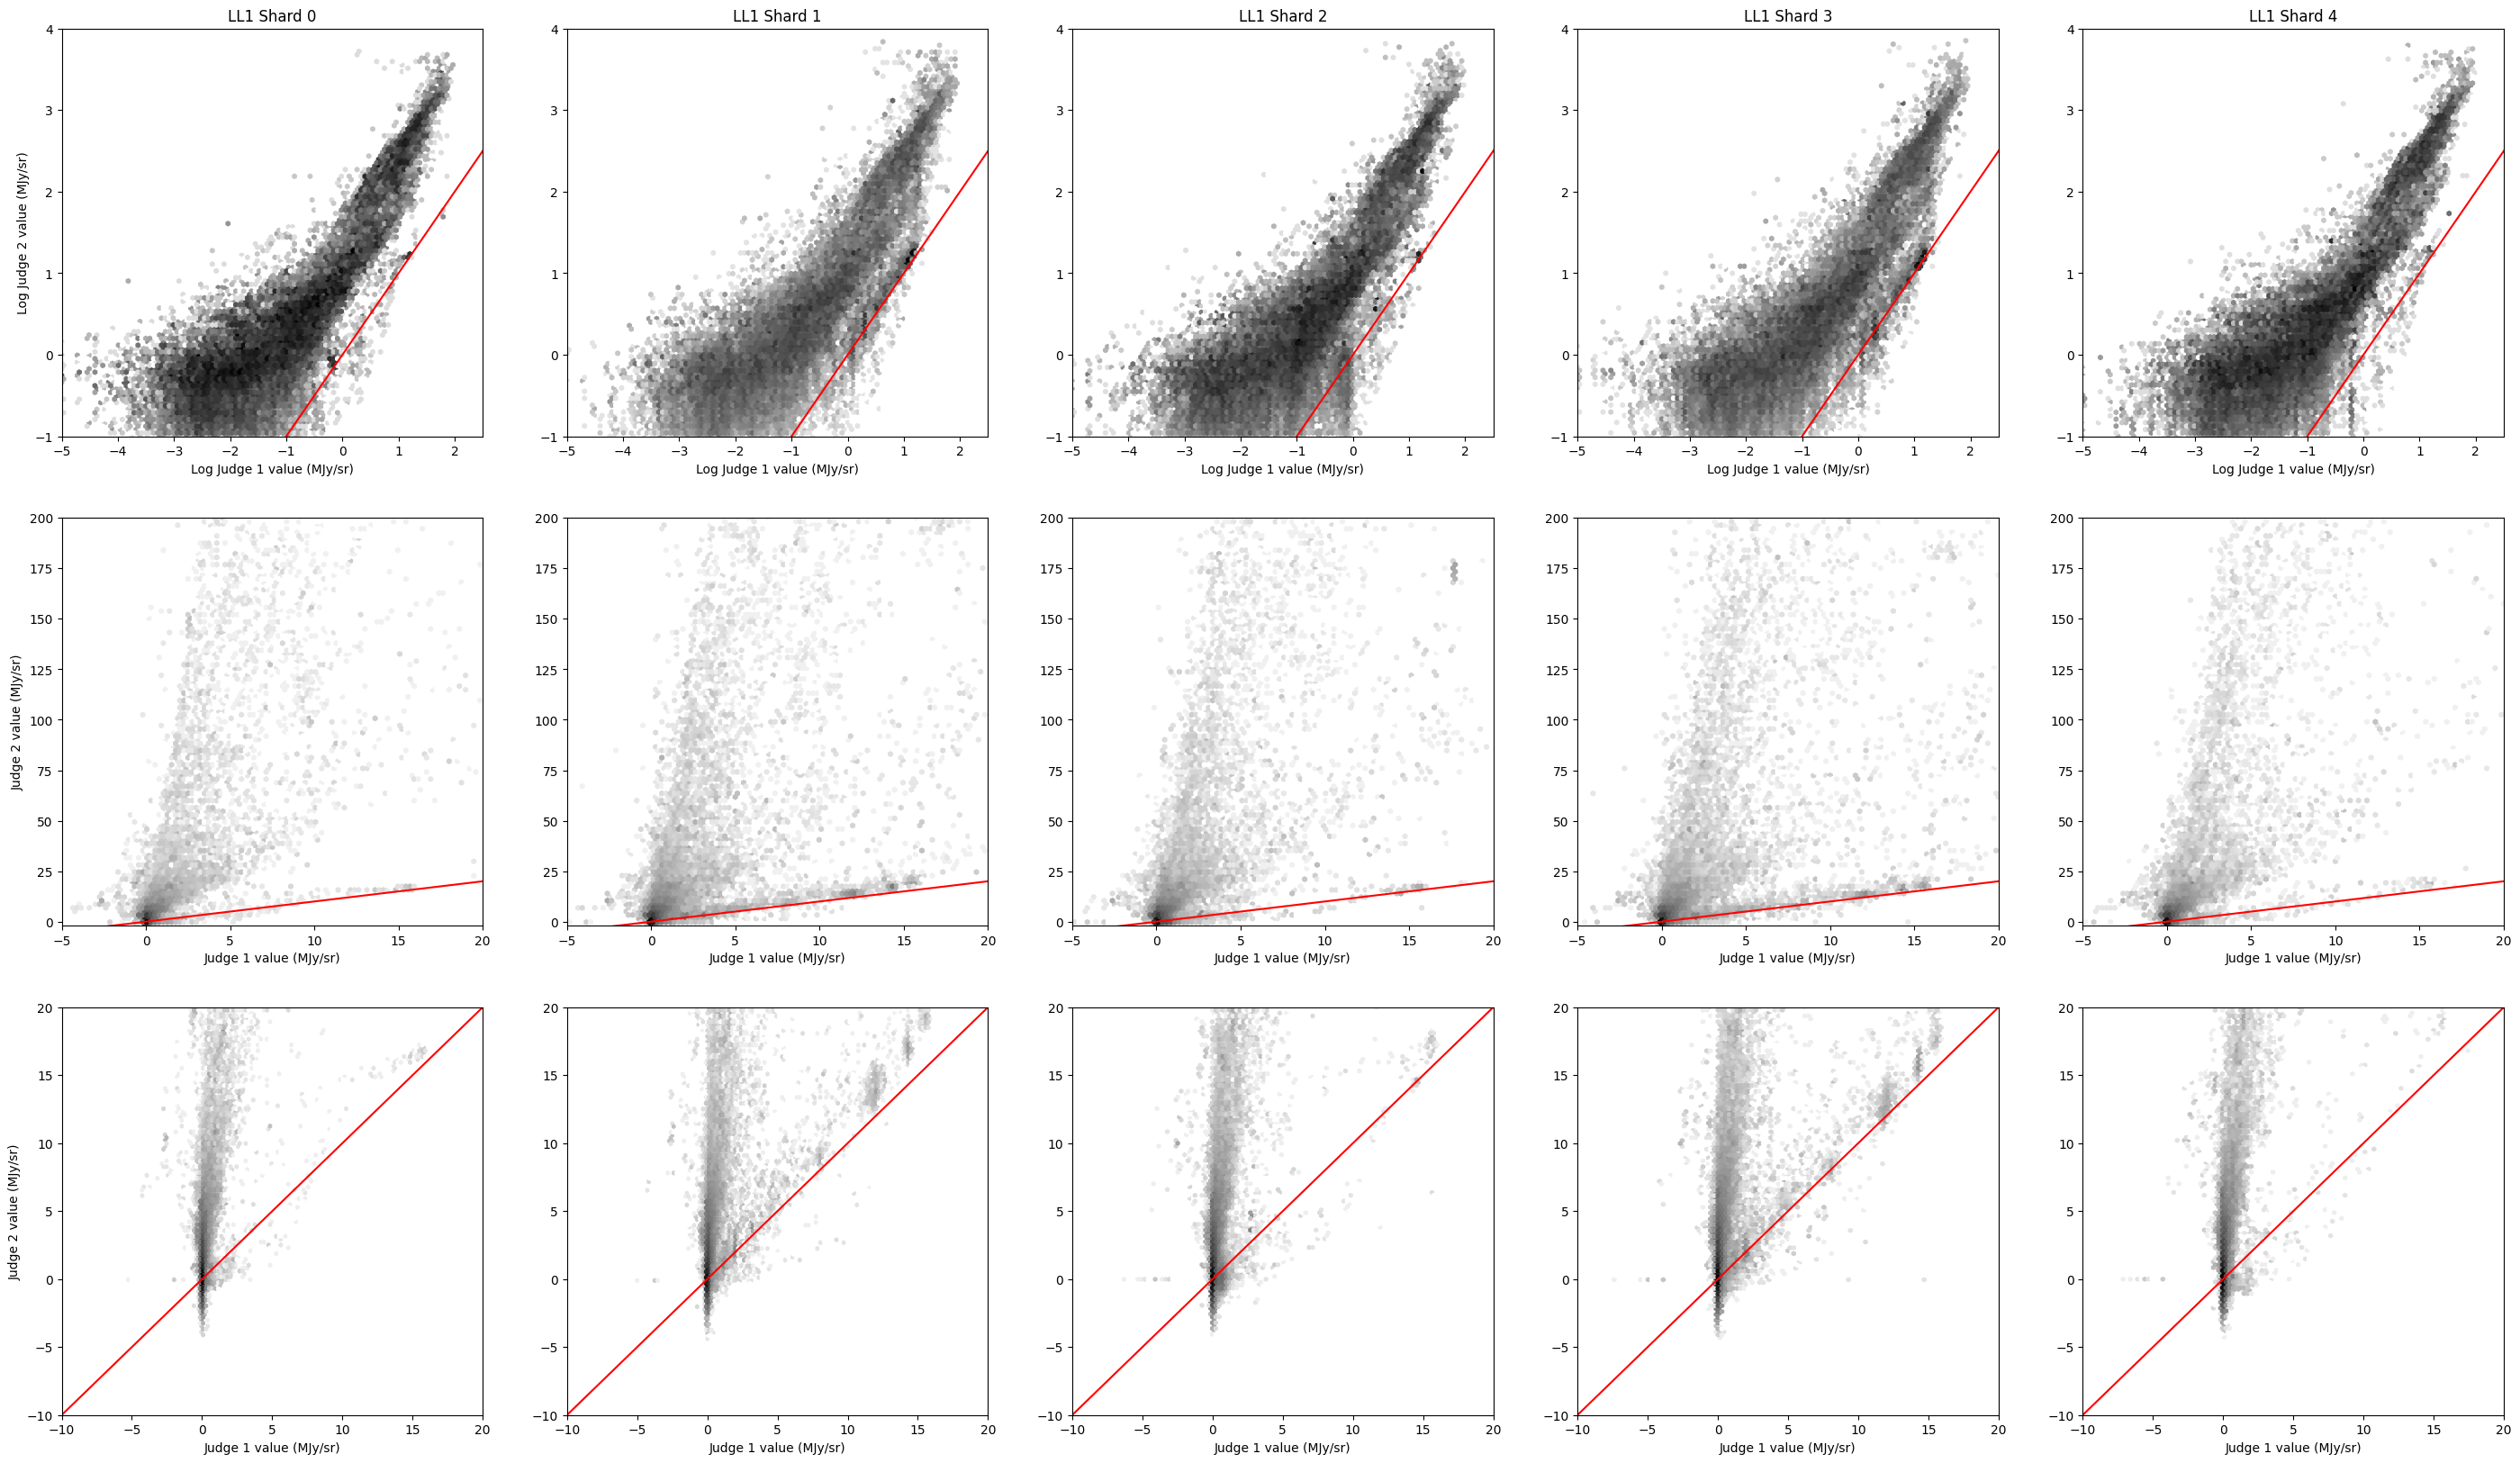

In [8]:
# LL1
fig, axs = plt.subplots(3, ll_n_shards, figsize=(35, 20))
xy = np.linspace(-10**10, 10**10)
xlim = (-5, 2.5)
ylim = (-1, 4)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, i+1)
    mask = np.where((chnls==2)&(subs==1)&(shards==i)&\
                   ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
                   ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
    j1, j2 = np.log10(j1s[mask]), np.log10(j2s[mask])
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.title('LL1 Shard '+str(i))
    plt.xlabel('Log Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Log Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-5, 20)
ylim = (-2, 200)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, (i+1)+ll_n_shards)
    mask = np.where((chnls==2)&(subs==1)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-10, 20)
ylim = (-10, 20)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, (i+1)+(ll_n_shards*2))
    mask = np.where((chnls==2)&(subs==1)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
plt.savefig(plotpath+'/judge_comparisons/LL1_judge_comparisons.pdf', format='pdf')
plt.show()

/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3614649182.py:9: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3614649182.py:10: RuntimeWarning: divide by zero encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
/var/folders/97/rd7y9sfd15b6y_7q_dw7j5yh0000gn/T/ipykernel_8538/3614649182.py:10: RuntimeWarning: invalid value encountered in log10
  ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))


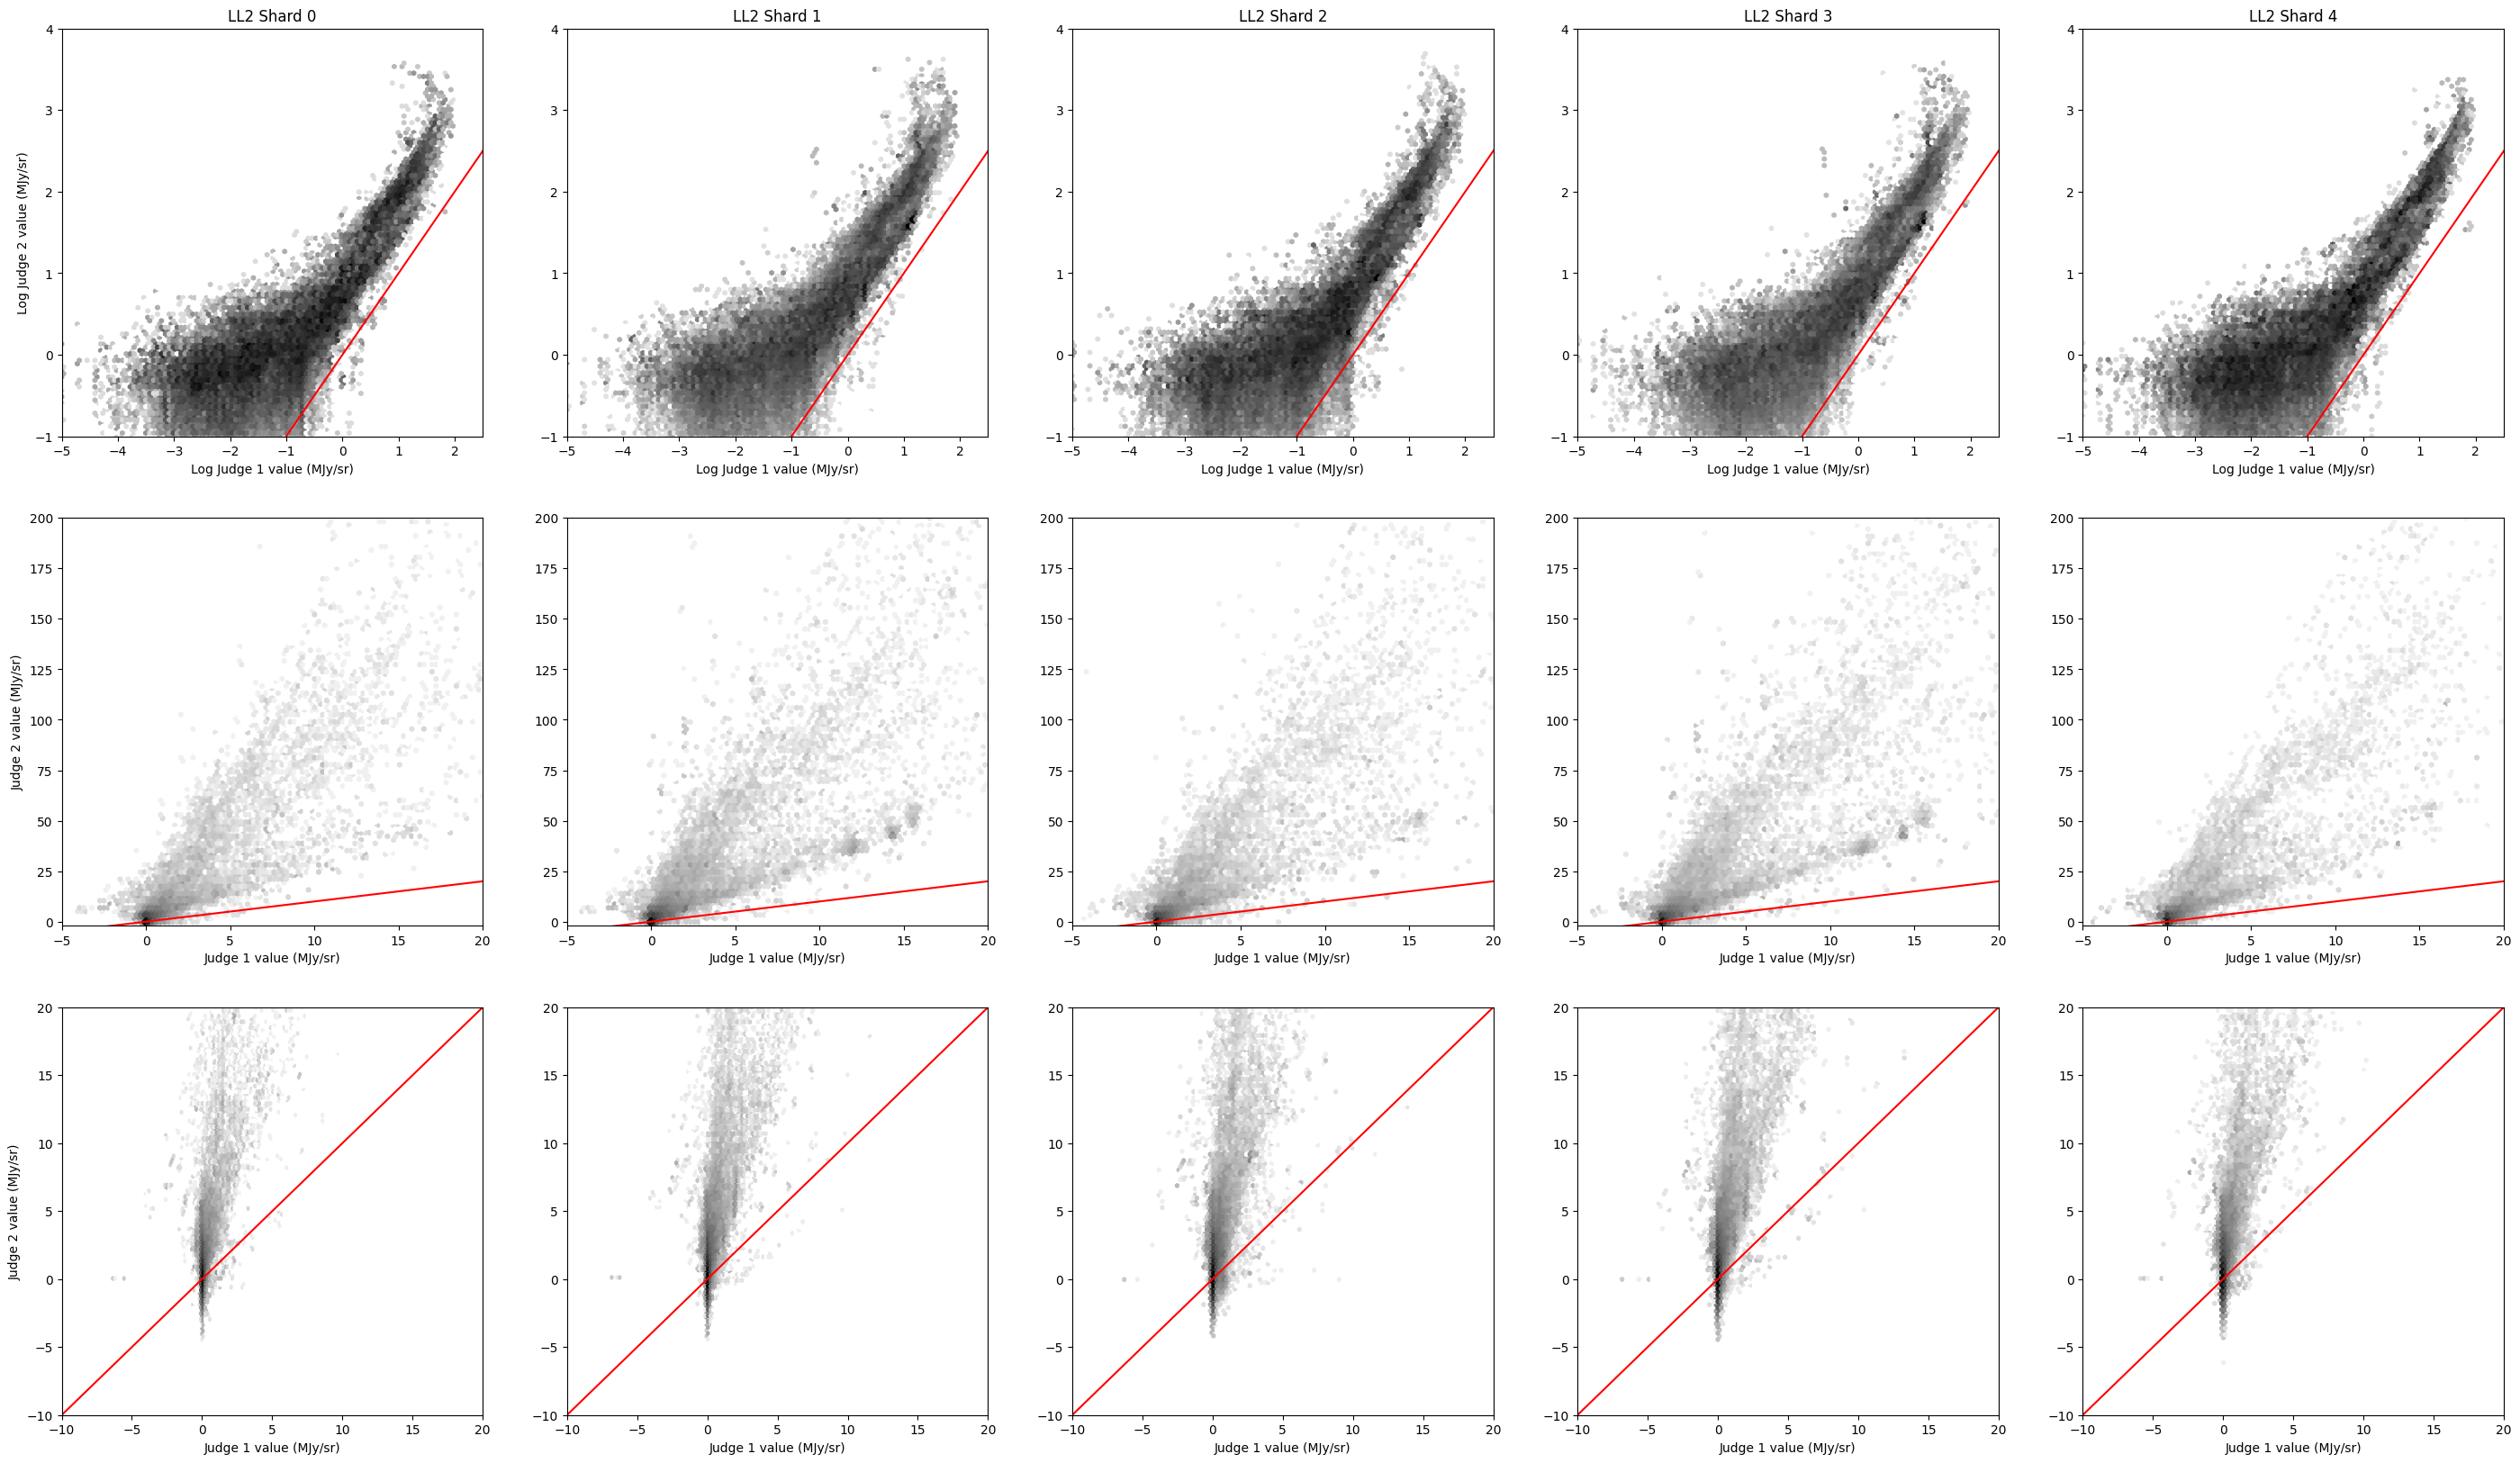

In [9]:
# LL2
fig, axs = plt.subplots(3, ll_n_shards, figsize=(35, 20))
xy = np.linspace(-10**10, 10**10)
xlim = (-5, 2.5)
ylim = (-1, 4)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, i+1)
    mask = np.where((chnls==2)&(subs==2)&(shards==i)&\
                   ((np.log10(j1s)>=xlim[0])&(np.log10(j1s)<=xlim[1]))&\
                   ((np.log10(j2s)>=ylim[0])&(np.log10(j2s)<=ylim[1])))
    j1, j2 = np.log10(j1s[mask]), np.log10(j2s[mask])
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.title('LL2 Shard '+str(i))
    plt.xlabel('Log Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Log Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-5, 20)
ylim = (-2, 200)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, (i+1)+ll_n_shards)
    mask = np.where((chnls==2)&(subs==2)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

xlim = (-10, 20)
ylim = (-10, 20)
for i in range(ll_n_shards):
    plt.subplot(3, ll_n_shards, (i+1)+(ll_n_shards*2))
    mask = np.where((chnls==2)&(subs==2)&(shards==i)&\
                   ((j1s>=xlim[0])&(j1s<=xlim[1]))&\
                   ((j2s>=ylim[0])&(j2s<=ylim[1])))
    j1, j2 = j1s[mask], j2s[mask]
    plt.hexbin(x=j1, y=j2, cmap='gray_r', bins='log', mincnt=1, gridsize=100)
    plt.plot(xy, xy, color='red')
    plt.xlabel('Judge 1 value (MJy/sr)')
    if i == 0:
        plt.ylabel('Judge 2 value (MJy/sr)')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
plt.savefig(plotpath+'/judge_comparisons/LL2_judge_comparisons.pdf', format='pdf')
plt.show()

# Shard Alignment Examples

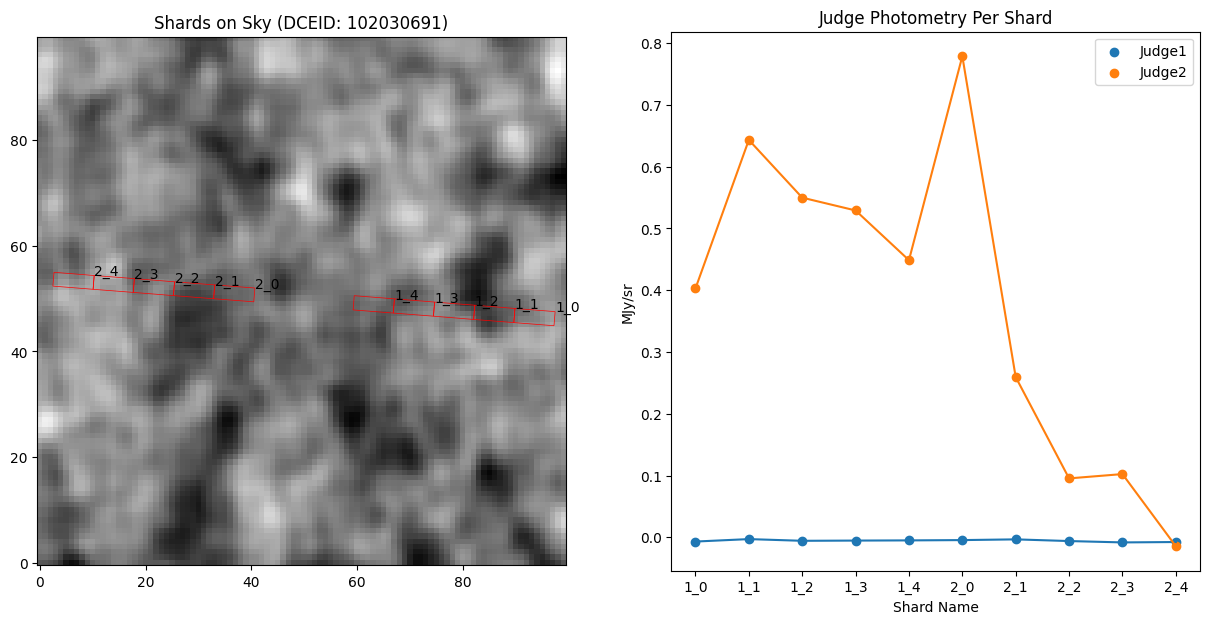

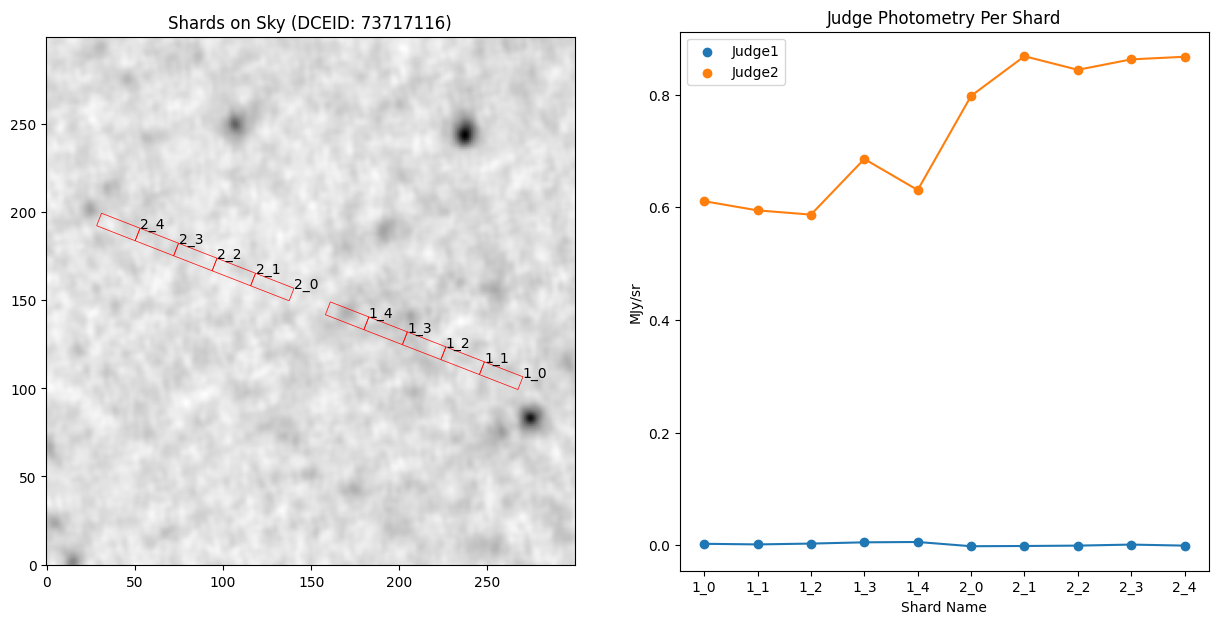

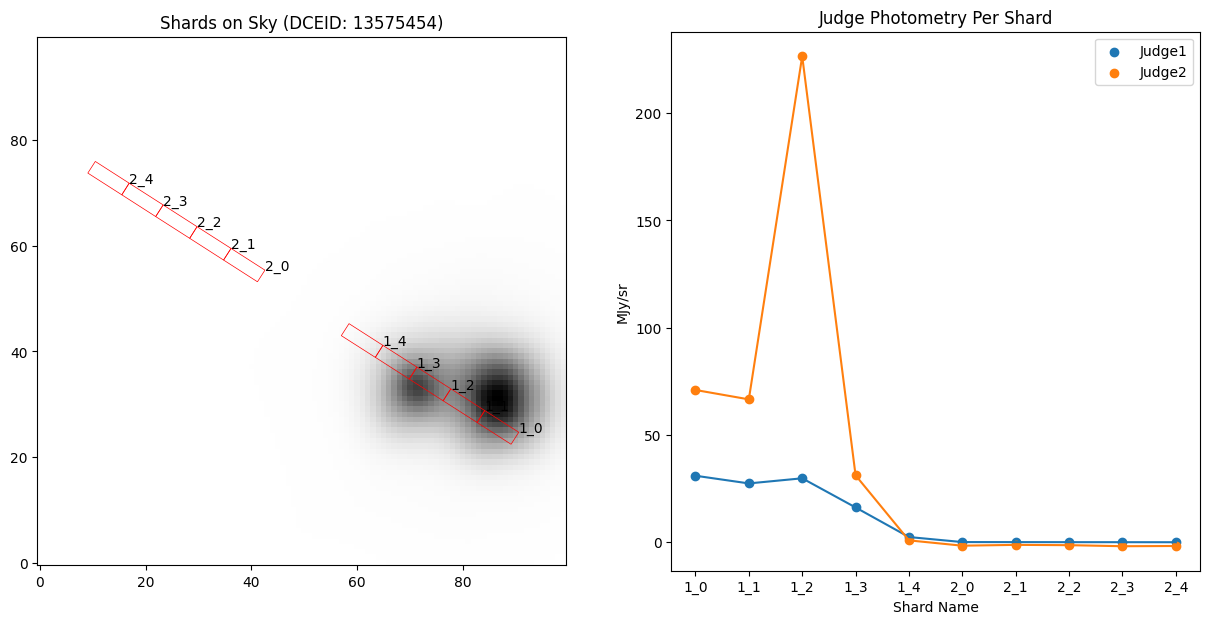

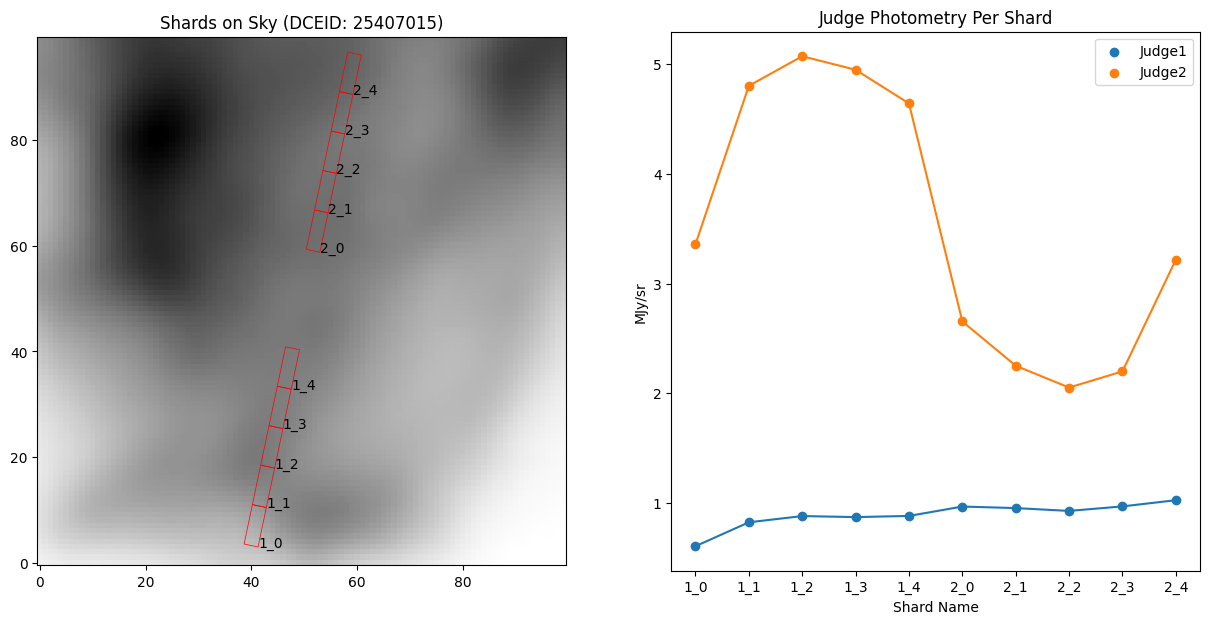

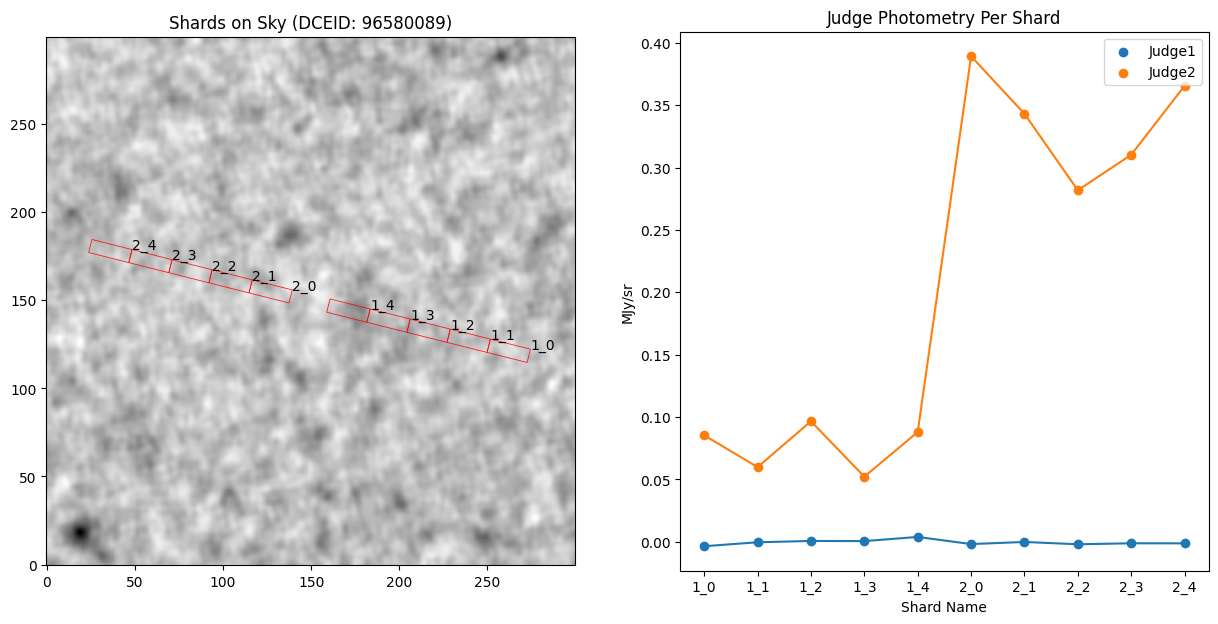

In [10]:
sample = query(simladbX.select(DB_bcd.DCEID, DB_bcd.CHNLNUM, DB_bcdwise.WISE_FILE)\
                       .where((DB_judge1.BACKSUB_PHOT!=0.0)).limit(10000))
randmask = np.random.randint(0, 10000, 5)
dceids, chnls, wisefiles = \
    sample['DCEID'][randmask].to_numpy(), \
    sample['CHNLNUM'][randmask].to_numpy(), \
    wisepath+sample['WISE_FILE'][randmask].to_numpy()

for i in range(len(dceids)):
    
    dceid, chnl, wisefile = dceids[i], chnls[i], wisefiles[i]
    shardq = query(simladbX.select( \
                    *scorners, DB_shardpos.SUBORDER, DB_shardpos.SHARD, \
                    DB_judge1.BACKSUB_PHOT, DB_judge2.F_MEDIAN) \
                   .where((DB_bcd.DCEID==dceid) & (DB_judge1.BACKSUB_PHOT!=0.0)))
    corners, subs, shardids, j1s, j2s = \
        fmt_scorners(shardq), shardq['SUBORDER'].to_numpy(), shardq['SHARD'].to_numpy(), \
        shardq['BACKSUB_PHOT'].to_numpy(), shardq['F_MEDIAN'].to_numpy()
    
    if chnl == 0: imsize = 100
    if chnl == 2: imsize = 300
    imdat, head, wcs = zoom_image([np.mean(corners.T[0]), np.mean(corners.T[1])], imsize, wisefile)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    for c in range(len(corners)):
        rectangle = corners[c]
        pixel_rect = []
        for p in rectangle:
            sky_c = SkyCoord(p[0],p[1],unit='deg')
            pixel_p = astropy.wcs.utils.skycoord_to_pixel(sky_c, wcs)
            pixel_rect.append(pixel_p)
        poly = plt.Polygon(pixel_rect, edgecolor='red', facecolor='none', ls='-', lw=0.5) 
        axs[0].add_patch(poly)
        plt.text(pixel_rect[0][0], pixel_rect[0][1], str(subs[c])+'_'+str(shardids[c]), color='black', size=10)
    plt.title('Shards on Sky (DCEID: '+str(dceid)+')')
    plt.imshow(imdat, cmap='gray_r', origin='lower')
    
    plt.subplot(1, 2, 2)
    names, sj1, sj2 = [], [], []
    for c in range(len(corners)):
        name = str(subs[c])+'_'+str(shardids[c])
        names.append(name)
        sj1.append(j1s[c])
        sj2.append(j2s[c])
    plt.title('Judge Photometry Per Shard')
    plt.scatter(names, sj1, label='Judge1')
    plt.plot(names, sj1)
    plt.scatter(names, sj2, label='Judge2')
    plt.plot(names, sj2)
    plt.xlabel('Shard Name')
    plt.ylabel('MJy/sr')
    plt.legend()
    
    plt.savefig(plotpath+'shard_alignment_examples/'+str(dceid)+'.pdf', format='pdf')
    plt.show()

# Stoplight Plot Examples

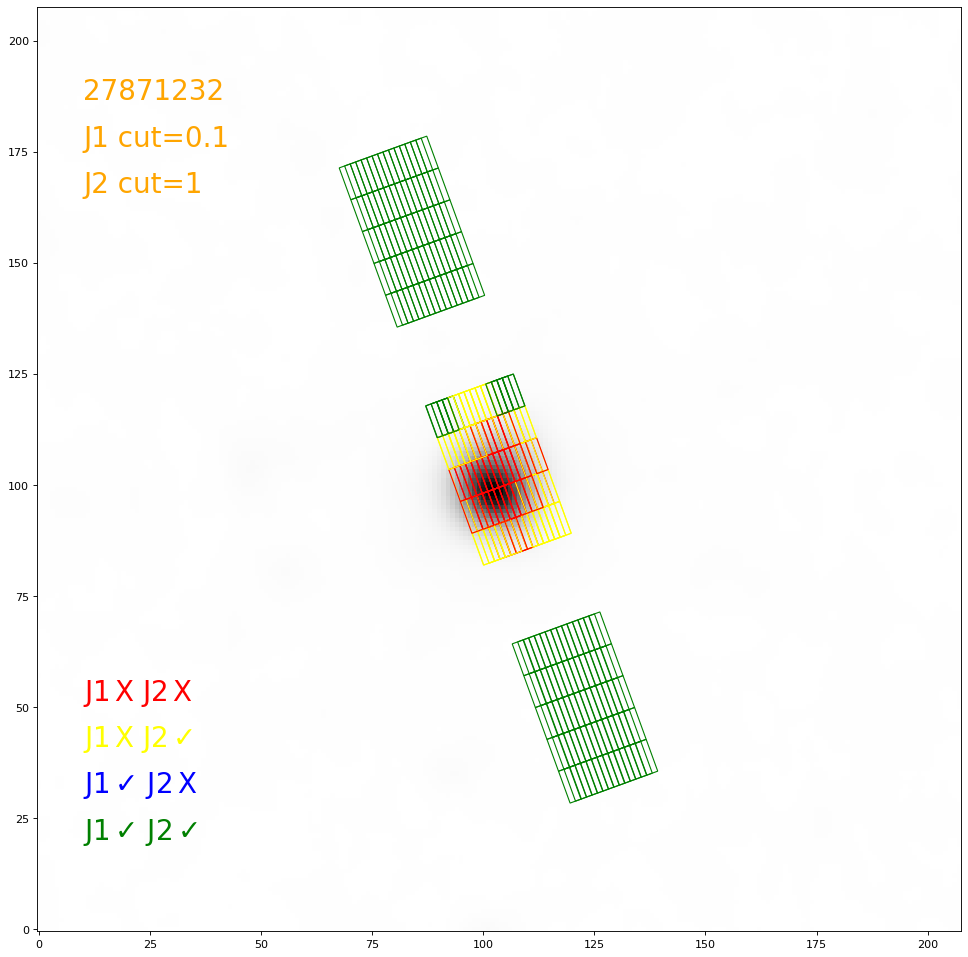

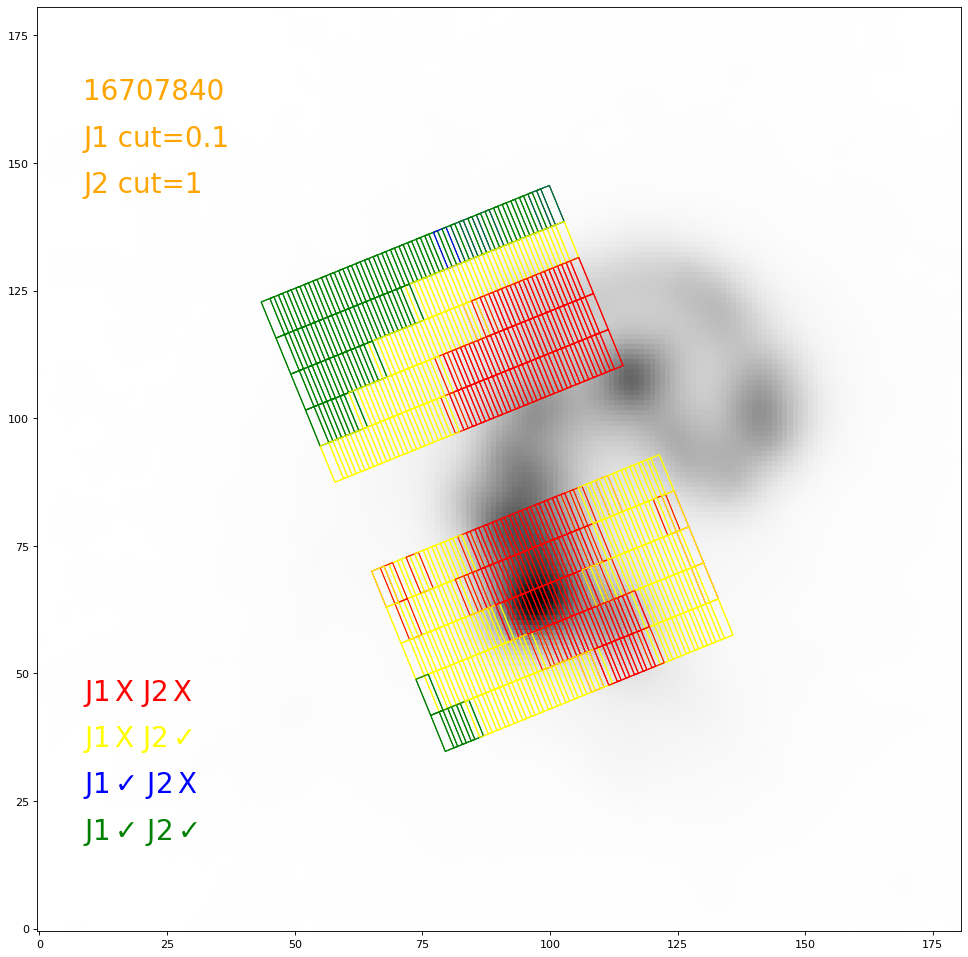

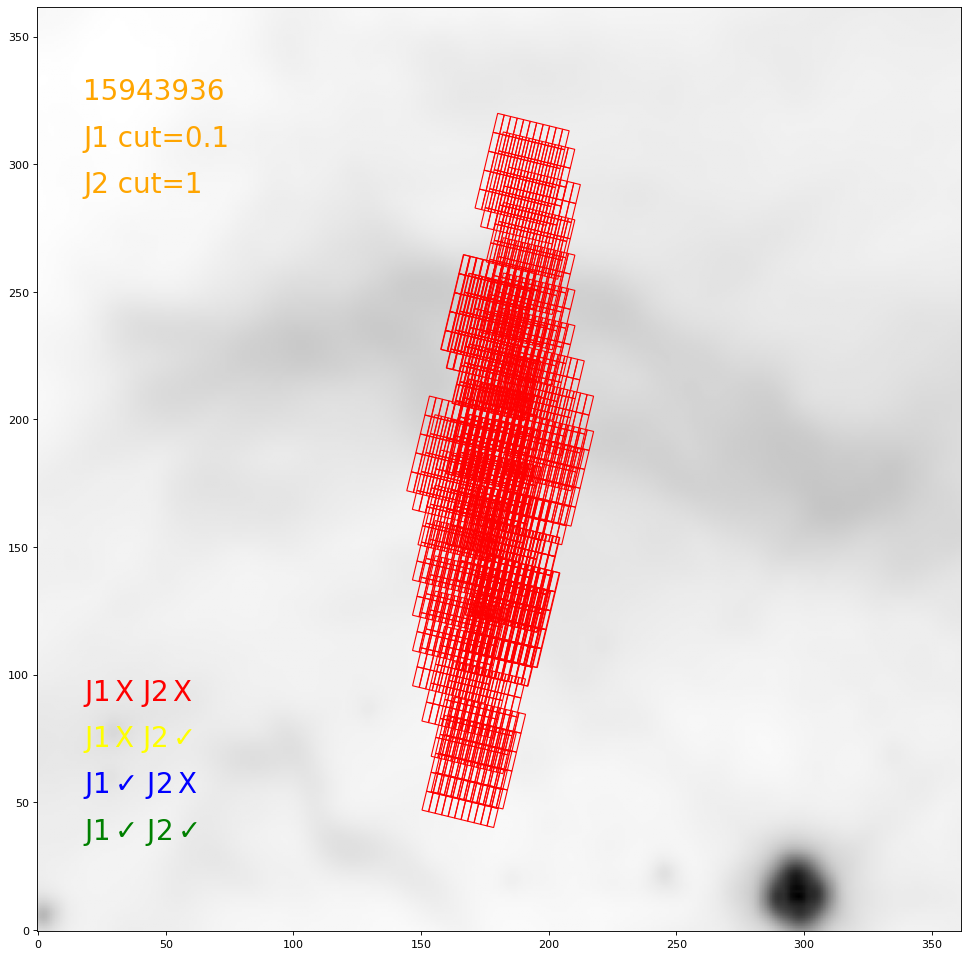

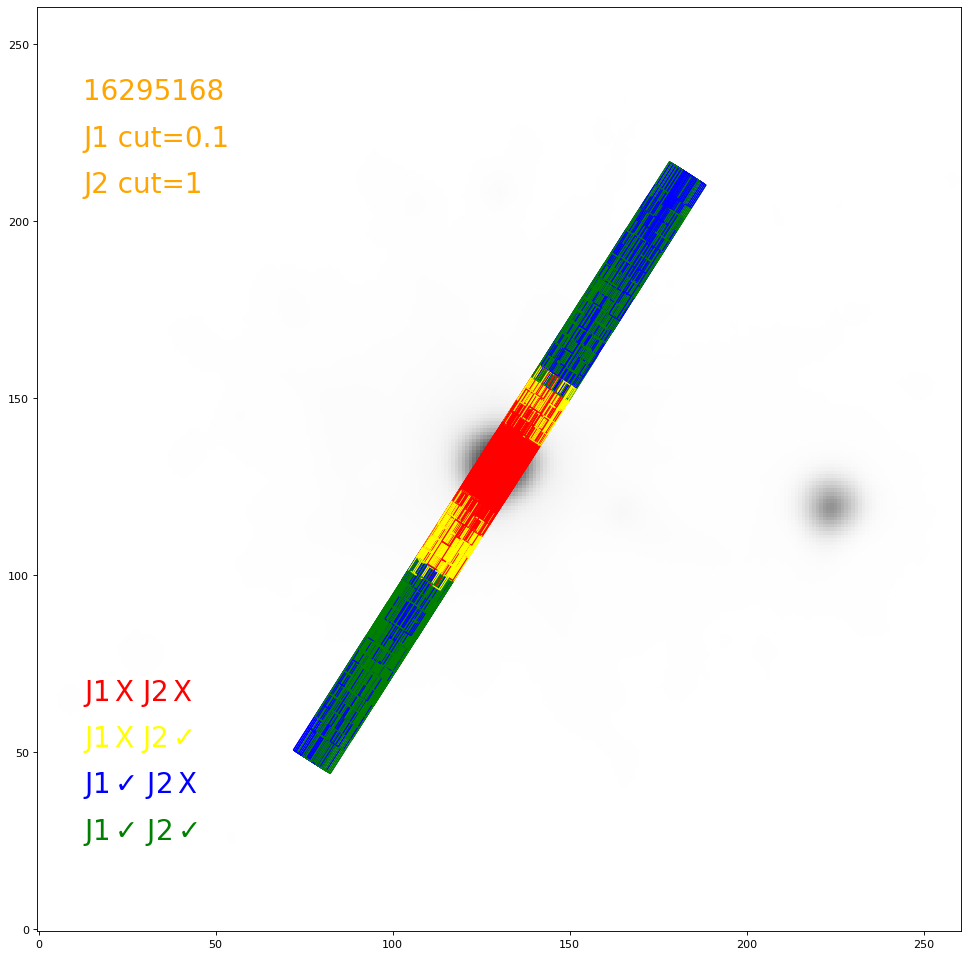

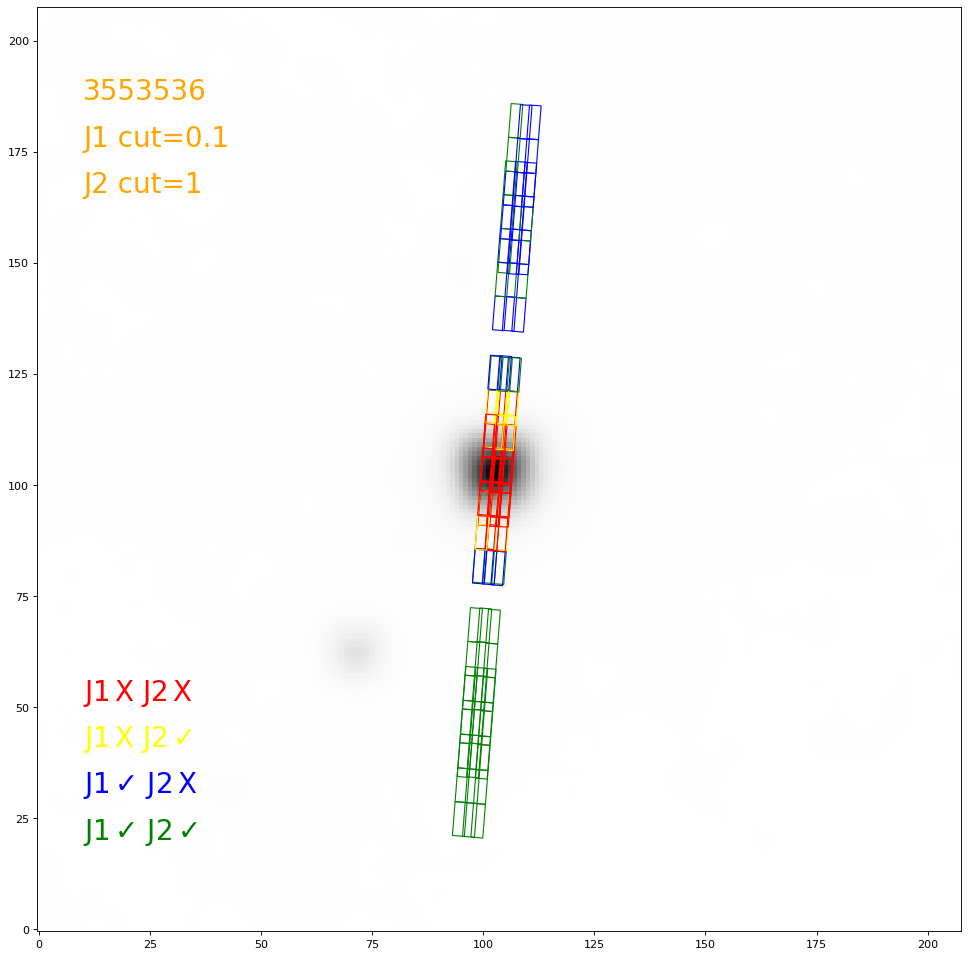

In [11]:
j1cut, j2cut = 0.1, 1

sample = query(simladbX.select(DB_bcd.AORKEY, DB_bcd.CHNLNUM).where((DB_judge1.BACKSUB_PHOT!=0.0)).limit(100000))
randmask = np.random.randint(0, 100000, 5)
aorkeys, chnls = \
    sample['AORKEY'][randmask].to_numpy(), \
    sample['CHNLNUM'][randmask].to_numpy()
for i in range(len(aorkeys)):
    validation_funcs.make_stoplight(aorkeys[i], j1cut, j2cut, chnls[i], \
                                    save=plotpath+'stoplight_examples/'+str(aorkeys[i])+'_'+str(chnls[i])+'.pdf')